In [1]:
import matplotlib
import matplotlib.pylab as plt
import glob
import numpy
import math
from joblib import Parallel, delayed

# Configuration
RUN_ID = "1"
RUNNING_TIME = 20

In [2]:
def res_dir(rid):
    return "results/" + rid

In [8]:
def process_log(filename):
    print("Processing", filename)

    publications = {}
    latencies = {}
    max_time = 0
    sync_pack = 0
    sync_byte = 0
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                    
                continue
            
            line = [x.strip() for x in line.split(',')]
            
            time = float(line[0])
            node = line[1]
            mtype = line[2]
            mid = line[3]
            
            if mtype == 'PUB':
                publications[mid] = time
            
            if mtype == 'RECV':
                if mid not in latencies:
                    latencies[mid] = []
                latencies[mid].append(time - publications[mid])
                
            max_time = max(max_time, time)
    
    return latencies, max_time, sync_pack, sync_byte

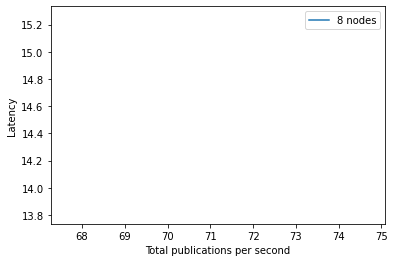

In [12]:
def add_plot(r, label):
    lists = sorted(r.items())
    x, y = zip(*lists)
    plt.plot(x, y, label=label)

jobs = []
    
def run_job(rid, label, scale):
    logfiles = glob.glob(res_dir(rid) + "/*.log")
    percentile = 90

    results50 = {}
    results90 = {}
    results_pack = {}
    results_byte = {}

    def set_p(res, max_time, sync_pack, sync_byte):
        nums50 = []
        nums90 = []
        for r in res:
            nums50.append(numpy.percentile(res[r], 50))
            nums90.append(numpy.percentile(res[r], 90))

        k = len(res)/(max_time/1000)
        results50[k] = numpy.average(nums50) / scale
        results90[k] = numpy.average(nums90) / scale
        results_pack[k] = sync_pack
        results_byte[k] = sync_byte

    for lf in logfiles:
        set_p(*process_log(lf))

    return results90, results50, label, results_pack, results_byte
    
def add_run(rid, label, scale):
    jobs.append(delayed(run_job)(rid, label, scale))

def run_jobs():
    res = Parallel(n_jobs=-1)(jobs)
    for r in res:
        add_plot(r[0], r[2])
    
# add_run("4", "4 nodes", math.sqrt(4))
add_run("8-n", "8 nodes", math.sqrt(8))
#add_run("16-n", "16 nodes", math.sqrt(16))
#add_run("32-n", "32 nodes", math.sqrt(32))
# add_run("64-n", "64 nodes", math.sqrt(64))

#add_run("8", "8 nodes (frag)", math.sqrt(8))
#add_run("16", "16 nodes (frag)", math.sqrt(16))
#add_run("32", "32 nodes (frag)", math.sqrt(32))
# add_run("64", "64 nodes (frag)", math.sqrt(64))
# add_run("128", "128 nodes", math.sqrt(128))

run_jobs()
    
plt.xlabel("Total publications per second")
plt.ylabel("Latency")
plt.legend()
plt.show()